In [18]:
import os

import math
import time
import random
from contextlib import contextmanager

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm

import cv2

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, 
    ShiftScaleRotate, Transpose
    )
from albumentations.pytorch import ToTensorV2

import timm

import warnings 
warnings.filterwarnings('ignore')

#from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Log in to your W&B account
import wandb

# Use wandb-core
wandb.require("core")

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# CONFIG

In [19]:
CFG = {}

CFG["project_name"]="NEW PROJECT"
CFG["debug"]=False
CFG["apex"]=False
CFG["print_freq"]=100
CFG["num_workers"]=4
CFG["model_name"]='resnext50_32x4d'
CFG["size"]=256
CFG["scheduler"]='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
CFG["epochs"]=3
#CFG["factor"]=0.2 # ReduceLROnPlateau
#CFG["patience"]=4 # ReduceLROnPlateau
#CFG["eps"]=1e-6 # ReduceLROnPlateau
#CFG["T_max"]=10 # CosineAnnealingLR
CFG["T_0"]=10 # CosineAnnealingWarmRestarts
CFG["lr"]=1e-4
CFG["min_lr"]=1e-6
CFG["batch_size"]=32
CFG["weight_decay"]=1e-6
CFG["gradient_accumulation_steps"]=1
CFG["max_grad_norm"]=1000
CFG["seed"]=42
CFG["target_size"]=5
CFG["target_col"]='label'
CFG["n_fold"]=1 #1 for train-val split
CFG["train_val_split"] = 0.1
CFG["trn_fold"]=[0, 1, 2, 3, 4]
CFG["train"]=True
CFG["inference"]=False


In [20]:
if CFG["debug"]:
    CFG["epochs"] = 1
    train = train.sample(n=1000, random_state=CFG["seed"]).reset_index(drop=True)
    
wandb.init(
    project=CFG["project_name"],
    config=dict(CFG)
)

OUTPUT_DIR = './output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = 'data/cassava-leaf-disease/train_images'
TEST_PATH = 'data/cassava-leaf-disease/test_images'

# UTILS

In [21]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG["seed"])

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

# DATA

In [22]:
train = pd.read_csv('data/cassava-leaf-disease/train.csv')
test = pd.read_csv('data/cassava-leaf-disease/sample_submission.csv')
label_map = pd.read_json('data/cassava-leaf-disease/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [23]:
train['label'].value_counts()

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64

In [24]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

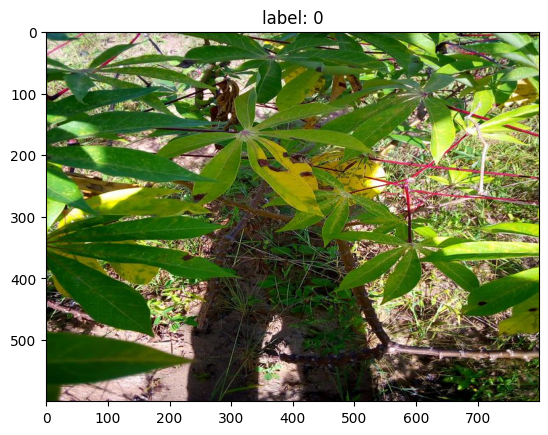

In [25]:
import matplotlib.pyplot as plt

train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [26]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG["size"], CFG["size"]),
            RandomResizedCrop(CFG["size"], CFG["size"]),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG["size"], CFG["size"]),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

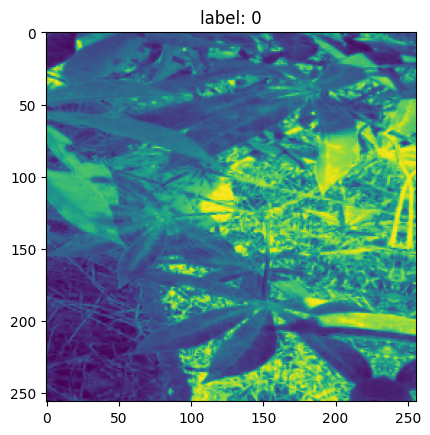

In [27]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# VALIDATION SPLIT

In [28]:
folds = train.copy()

if CFG["n_fold"] == 1:
    tmp = CFG["train_val_split"]*100
    folds['fold'] = [1 if random.randint(0,tmp) < tmp else 0 for x in range(len(folds))]
    print(folds.groupby(['fold', CFG["target_col"]]).size())
else:
    Fold = StratifiedKFold(n_splits=CFG["n_fold"], shuffle=True, random_state=CFG["seed"])
    for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG["target_col"]])):
        folds.loc[val_index, 'fold'] = int(n)
    folds['fold'] = folds['fold'].astype(int)
    print(folds.groupby(['fold', CFG["target_col"]]).size())

fold  label
0     0          100
      1          213
      2          214
      3         1250
      4          240
1     0          987
      1         1976
      2         2172
      3        11908
      4         2337
dtype: int64


# MODEL

In [29]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG["target_size"])

    def forward(self, x):
        x = self.model(x)
        return x

In [30]:
model = CustomResNext(model_name=CFG["model_name"], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1282,  0.0546,  0.2061,  0.4135,  0.0802],
        [ 0.0829,  0.0571, -0.0082,  0.4674, -0.0448],
        [ 0.1793,  0.1260,  0.0225,  0.4232, -0.0036],
        [ 0.1038, -0.0474,  0.0653,  0.5665,  0.1437]],
       grad_fn=<AddmmBackward0>)


# EPOCH

In [31]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        if CFG["apex"]:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["max_grad_norm"])
        if (step + 1) % CFG["gradient_accumulation_steps"] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# TRAIN LOOP

In [32]:
%%wandb

def train_loop(folds, fold):

    LOGGER.info(f"Fold: {fold} training")

    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG["batch_size"], 
                              shuffle=True, 
                              num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG["batch_size"], 
                              shuffle=False, 
                              num_workers=CFG["num_workers"], pin_memory=True, drop_last=False)

    def get_scheduler(optimizer):
        if CFG["scheduler"]=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG["factor"], patience=CFG["patience"], verbose=True, eps=CFG["eps"])
        elif CFG["scheduler"]=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
        elif CFG["scheduler"]=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG["T_0"], T_mult=1, eta_min=CFG["min_lr"], last_epoch=-1)
        return scheduler


    model = CustomResNext(CFG["model_name"], pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = get_scheduler(optimizer)

    if CFG["apex"]:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)


    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG["epochs"]):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG["target_col"]].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG["model_name"]}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG["model_name"]}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [33]:
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG["target_col"]].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG["train"]:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG["n_fold"]):
            if fold in CFG["trn_fold"]:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"Fold: {fold}")
                get_result(_oof_df)
        # CV result
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG["inference"]:
        # inference
        model = CustomResNext(CFG["model_name"], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG["model_name"]}_fold{fold}_best.pth') for fold in CFG["trn_fold"]]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, 
                                 num_workers=CFG["num_workers"], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [34]:
if __name__ == '__main__':
    main()

Fold: 0 training
Fold: 0 training
INFO:__main__:Fold: 0 training
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnext50_32x4d.a1h_in1k)
INFO:timm.models._hub:[timm/resnext50_32x4d.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Epoch: [1][0/605] Data 0.266 (0.266) Elapsed 0m 0s (remain 6m 49s) Loss: 1.6303(1.6303) Grad: 5.1716  
Epoch: [1][100/605] Data 0.000 (0.003) Elapsed 0m 11s (remain 0m 56s) Loss: 1.0341(1.1827) Grad: 5.9562  
Epoch: [1][200/605] Data 0.000 (0.002) Elapsed 0m 21s (remain 0m 43s) Loss: 1.1048(1.0397) Grad: 7.2185  
Epoch: [1][300/605] Data 0.000 (0.001) Elapsed 0m 31s (remain 0m 32s) Loss: 0.9171(0.9555) Grad: 9.0605  
Epoch: [1][400/605] Data 0.000 (0.001) Elapsed 0m 42s (remain 0m 21s) Loss: 0.5678(0.8967) Grad: 6.2977  
Epoch: [1][500/605] Data 0.000 (0.001) Elapsed 0m 52s (remain 0m 10s) Loss: 0.6477(0.8473) Grad: 5.4486  
Epoch: [1][600/605] Data 0.000 (0.001) Elapsed 1m 3s (remain 0m 0s) Loss: 0.5707(0.8036) Grad: 5.4987  
Epoch: [1][604/605] Data 0.000 (0.001) Elapsed 1m 3s (remain 0m 0s) Loss: 0.6327(0.8033) Grad: 8.2397  
EVAL: [0/64] Data 0.225 (0.225) Elapsed 0m 0s (remain 0m 15s) Loss: 0.3365(0.3365) 


Epoch 1 - avg_train_loss: 0.8033  avg_val_loss: 0.5412  time: 66s
Epoch 1 - avg_train_loss: 0.8033  avg_val_loss: 0.5412  time: 66s
INFO:__main__:Epoch 1 - avg_train_loss: 0.8033  avg_val_loss: 0.5412  time: 66s
Epoch 1 - Accuracy: 0.812097174020823
Epoch 1 - Accuracy: 0.812097174020823
INFO:__main__:Epoch 1 - Accuracy: 0.812097174020823
Epoch 1 - Save Best Score: 0.8121 Model
Epoch 1 - Save Best Score: 0.8121 Model
INFO:__main__:Epoch 1 - Save Best Score: 0.8121 Model


EVAL: [63/64] Data 0.000 (0.004) Elapsed 0m 1s (remain 0m 0s) Loss: 0.9833(0.5412) 
Epoch: [2][0/605] Data 0.265 (0.265) Elapsed 0m 0s (remain 3m 45s) Loss: 0.8071(0.8071) Grad: 8.7159  
Epoch: [2][100/605] Data 0.000 (0.003) Elapsed 0m 10s (remain 0m 54s) Loss: 0.4148(0.5645) Grad: 5.4036  
Epoch: [2][200/605] Data 0.000 (0.002) Elapsed 0m 21s (remain 0m 42s) Loss: 0.5386(0.5505) Grad: 6.3367  
Epoch: [2][300/605] Data 0.000 (0.001) Elapsed 0m 31s (remain 0m 31s) Loss: 0.6483(0.5466) Grad: 6.6486  
Epoch: [2][400/605] Data 0.000 (0.001) Elapsed 0m 42s (remain 0m 21s) Loss: 0.6376(0.5334) Grad: 7.3960  
Epoch: [2][500/605] Data 0.000 (0.001) Elapsed 0m 52s (remain 0m 10s) Loss: 0.4767(0.5247) Grad: 5.6533  
Epoch: [2][600/605] Data 0.000 (0.001) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4754(0.5262) Grad: 5.9886  
Epoch: [2][604/605] Data 0.000 (0.001) Elapsed 1m 3s (remain 0m 0s) Loss: 0.4750(0.5265) Grad: 5.9475  
EVAL: [0/64] Data 0.233 (0.233) Elapsed 0m 0s (remain 0m 16s) Loss: 0.2802(

Epoch 2 - avg_train_loss: 0.5265  avg_val_loss: 0.4837  time: 65s
Epoch 2 - avg_train_loss: 0.5265  avg_val_loss: 0.4837  time: 65s
INFO:__main__:Epoch 2 - avg_train_loss: 0.5265  avg_val_loss: 0.4837  time: 65s
Epoch 2 - Accuracy: 0.826970748636589
Epoch 2 - Accuracy: 0.826970748636589
INFO:__main__:Epoch 2 - Accuracy: 0.826970748636589
Epoch 2 - Save Best Score: 0.8270 Model
Epoch 2 - Save Best Score: 0.8270 Model
INFO:__main__:Epoch 2 - Save Best Score: 0.8270 Model


EVAL: [63/64] Data 0.000 (0.004) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1995(0.4837) 
Epoch: [3][0/605] Data 0.255 (0.255) Elapsed 0m 0s (remain 3m 39s) Loss: 0.5708(0.5708) Grad: 6.5217  
Epoch: [3][100/605] Data 0.000 (0.003) Elapsed 0m 10s (remain 0m 53s) Loss: 0.4232(0.4861) Grad: 4.8031  
Epoch: [3][200/605] Data 0.000 (0.002) Elapsed 0m 21s (remain 0m 42s) Loss: 0.6254(0.4889) Grad: 7.8467  
Epoch: [3][300/605] Data 0.000 (0.001) Elapsed 0m 31s (remain 0m 31s) Loss: 0.3596(0.4871) Grad: 4.9275  
Epoch: [3][400/605] Data 0.000 (0.001) Elapsed 0m 41s (remain 0m 21s) Loss: 0.3703(0.4864) Grad: 6.4979  
Epoch: [3][500/605] Data 0.000 (0.001) Elapsed 0m 52s (remain 0m 10s) Loss: 0.3621(0.4834) Grad: 4.8347  
Epoch: [3][600/605] Data 0.000 (0.001) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3388(0.4779) Grad: 4.3347  
Epoch: [3][604/605] Data 0.000 (0.001) Elapsed 1m 2s (remain 0m 0s) Loss: 0.5365(0.4776) Grad: 5.9111  
EVAL: [0/64] Data 0.247 (0.247) Elapsed 0m 0s (remain 0m 17s) Loss: 0.1944(

Epoch 3 - avg_train_loss: 0.4776  avg_val_loss: 0.4648  time: 65s
Epoch 3 - avg_train_loss: 0.4776  avg_val_loss: 0.4648  time: 65s
INFO:__main__:Epoch 3 - avg_train_loss: 0.4776  avg_val_loss: 0.4648  time: 65s
Epoch 3 - Accuracy: 0.834407535944472
Epoch 3 - Accuracy: 0.834407535944472
INFO:__main__:Epoch 3 - Accuracy: 0.834407535944472
Epoch 3 - Save Best Score: 0.8344 Model
Epoch 3 - Save Best Score: 0.8344 Model
INFO:__main__:Epoch 3 - Save Best Score: 0.8344 Model


EVAL: [63/64] Data 0.000 (0.004) Elapsed 0m 1s (remain 0m 0s) Loss: 0.1045(0.4648) 


Fold: 0
Fold: 0
INFO:__main__:Fold: 0
Score: 0.83441
Score: 0.83441
INFO:__main__:Score: 0.83441
Score: 0.83441
Score: 0.83441
INFO:__main__:Score: 0.83441


In [35]:
# inference
model = CustomResNext(CFG["model_name"], pretrained=False)
states = [torch.load(OUTPUT_DIR+f'{CFG["model_name"]}_fold{fold}_best.pth') for fold in CFG["trn_fold"]]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, 
                            num_workers=CFG["num_workers"], pin_memory=True)
predictions = inference(model, states, test_loader, device)
# submission
test['label'] = predictions.argmax(1)
test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

  0%|          | 0/1 [00:00<?, ?it/s]